<a href="https://colab.research.google.com/github/emilymaccarthy/Music-Genre-Clasiffier/blob/main/TP3_TD6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


**link al doc:** https://docs.google.com/document/d/1iC3hRQg9KKZVydiCQXA_GiRpU6Bo-CQ2jR1HKAPIIMA/edit?usp=sharing

In [ ]:
! pip install torchaudio
! pip install  pydub
!pip install wandb -qU
!export WANDB_API_KEY="a95c9a55fb9514b8525cfc91b011aeca88892820"


In [ ]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import wandb


In [ ]:
wandb.login()

True


# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [ ]:
project_name ='Music_genre_classification'

### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [ ]:
import os
#data_dir='/content/genres_5sec-20241026T141804Z-001.zip'

data_dir = '/content/drive/MyDrive/TD6/genres_5sec'

list_files=os.listdir(data_dir)
classes=[]
class_file_counts = {}
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
    num_files = len([f for f in os.listdir(name) if os.path.isfile(os.path.join(name, f))])
    class_file_counts[file] = num_files

for class_name, count in class_file_counts.items():
    print(f"Class: {class_name}, Number of files: {count}")

classes

Class: jazz, Number of files: 99
Class: metal, Number of files: 99
Class: rock, Number of files: 99
Class: country, Number of files: 99
Class: disco, Number of files: 99
Class: pop, Number of files: 99
Class: reggae, Number of files: 99
Class: classical, Number of files: 99
Class: blues, Number of files: 99
Class: hiphop, Number of files: 99


['jazz',
 'metal',
 'rock',
 'country',
 'disco',
 'pop',
 'reggae',
 'classical',
 'blues',
 'hiphop']

In [ ]:

samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]

        #img = self.transform(open_image(fpath))
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        return audio, class_idx
dataset = MusicDataset(data_dir)

### 3. Visualización de los archivos

In [ ]:
waveform,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 6 


shape of spectogram torch.Size([1, 201, 552])


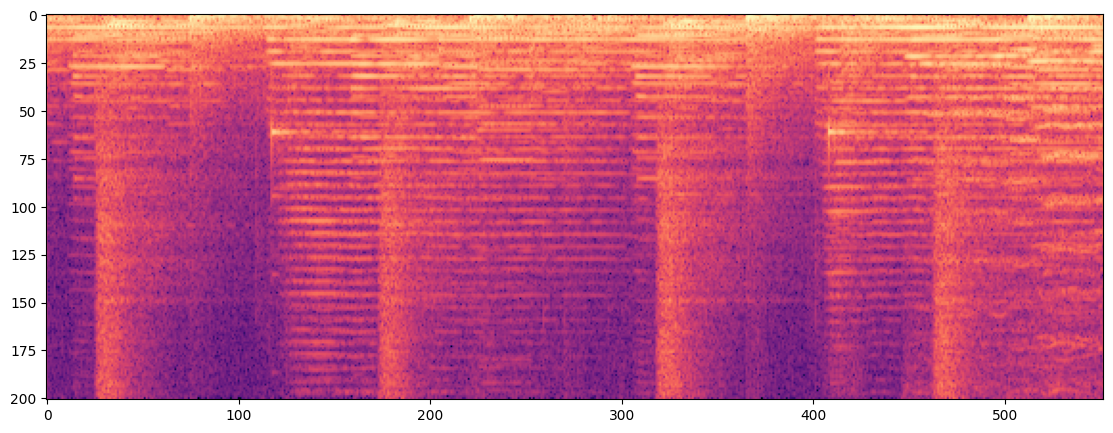

In [ ]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')


Waveform: tensor([[ 0.0024,  0.0055,  0.0087,  ..., -0.0035, -0.0028,  0.0053]])



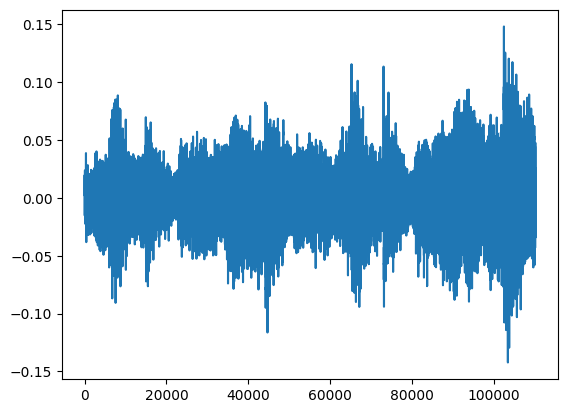

In [ ]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [ ]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [ ]:
specgram.size()

torch.Size([1, 201, 552])

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
#test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=2, pin_memory=True)

### 4. Clasificación

In [ ]:
hidden_dimensions = 64

class MLP(nn.Module):
    def __init__(self, n_input, hidden_dim=hidden_dimensions, n_output=10):
        super(MLP, self).__init__()
        # Define layers dynamically
        self.fc1 = nn.Linear(n_input, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, n_output)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # First hidden layer with ReLU
        #x = F.relu(self.fc2(x))  # Second hidden layer with ReLU
        #x = self.fc3(x)          # Output layer, no activation as it's used for logits
        return F.log_softmax(x, dim=1)



In [ ]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = MLP(n_input=110250, n_output=len(classes))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)



MLP(
  (fc1): Linear(in_features=110250, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 7060874


In [ ]:
len(classes)

10

In [ ]:

import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F

learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_losses = []
num_epochs = 5
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram

wandb.init(
    project="tp3-td6",
    config={
        "learning_rate": learning_rate,
        "architecture": "CNN",  # Cambiar a "MLP" para mayor claridad
        "dataset": "genres_5sec",
        "epochs": num_epochs,
        "batch_size": batch_size,  # Si tienes un tamaño de lote específico
        "hidden_dim": hidden_dimensions,  # Dimensión de las capas ocultas
        "optimizer": "Adam",  # Tipo de optimizador utilizado
        "loss_function": "NLLLoss",  # Función de pérdida utilizada
    }
)

for epoch in range(num_epochs):
    losses = []

    # Train
    model.train()
    for wav, genre_index in train_dl:
        optimizer.zero_grad()  # Clear gradients
        wav=wav.to(device)
        genre_index =torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(wav)
        #M5
        loss = F.nll_loss(out.squeeze(), genre_index)
        # loss = F.cross_entropy(out, genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))
    # # Log training loss to WandB
    # wandb.log({'train_loss': np.mean(losses), 'epoch': epoch + 1})


    # Validation
    model.eval()
    y_true = []
    y_pred = []
    losses = []
    correct =0
    for wav, genre_index in valid_dl:
        #print(wav, genre, index)
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        loss = F.nll_loss(out.squeeze() , genre_index)

        losses.append(loss.item())
        #M5
        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)
        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    accuracy =correct/ len(valid_dl.dataset)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))
    # log metrics to wandb
    wandb.log({"acc": accuracy, "loss": valid_loss})

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(model.state_dict(), 'best_model.ckpt')

wandb.finish()

Epoch: [1/5], Train loss: 0.0000
Epoch: [1/5], Valid loss: 0.0000, Valid accuracy: 0.1100
Saving the best model at 0 epochs!
Epoch: [2/5], Train loss: 0.0000
Epoch: [2/5], Valid loss: 0.0000, Valid accuracy: 0.1100
Epoch: [3/5], Train loss: 0.0000
Epoch: [3/5], Valid loss: 0.0000, Valid accuracy: 0.1100
Epoch: [4/5], Train loss: 0.0000
Epoch: [4/5], Valid loss: 0.0000, Valid accuracy: 0.1100
Epoch: [5/5], Train loss: 0.0000
Epoch: [5/5], Valid loss: 0.0000, Valid accuracy: 0.1100


acc,▁▁▁▁▁
loss,▁▁▁▁▁
acc,0.11
loss,0




### 5. Evaluación



In [ ]:
test_dl = DataLoader(test_ds,1,shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Load the best model
S = torch.load('best_model.ckpt')
model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for wav, genre_index in test_dl:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))


loaded!


<ipython-input-24-90ce37da13b0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  S = torch.load('best_model.ckpt')


Epoch: [5/5], Valid loss: 0.0000, Valid accuracy: 0.1200


In [ ]:
waveform,label= test_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 5 


In [ ]:
import IPython
IPython.display.Audio(waveform, rate=22050)

In [ ]:
wav= torch.unsqueeze(waveform, dim=0)
model.to(device)
wav =wav.to(device)
out = model(wav)
pred= out.argmax(dim=-1).flatten()
classes[pred], classes[label]

('jazz', 'pop')